# **Assignment: Three Hidden Layer Neural Network for Multi-Class Classification**

In [1]:
# Import required libraries
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

np.random.seed(42)

**Step 1: Generate synthetic dataset**

In [4]:
import pandas as pd
import numpy as np
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

# Generate synthetic dataset
# Using 5 classes as suggested by the output layer size in later cells
# 10 features, 3000 samples
X, y = make_classification(n_samples=3000, n_features=10, n_informative=8,
                           n_redundant=0, n_repeated=0, n_classes=5,
                           n_clusters_per_class=1, random_state=42)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Convert y to one-hot encoding for training the neural network
Y_train = np.eye(5)[y_train]
Y_test = np.eye(5)[y_test]

# Convert to pandas DataFrame (optional, for saving to CSV)
data = pd.DataFrame(X, columns=[f"X{i+1}" for i in range(X.shape[1])])
data["label"] = y  # add labels column

# Save as CSV
data.to_csv("five_class_dataset.csv", index=False)
print("Dataset saved as 'five_class_dataset.csv'")


Dataset saved as 'five_class_dataset.csv'


**Step 2: Define Neural Network class with three hidden layers**

In [6]:
class NeuralNetwork:
    def __init__(self, layer_sizes, learning_rate=0.01, seed=42):
        np.random.seed(seed)
        self.layer_sizes = layer_sizes
        self.num_layers = len(layer_sizes) - 1
        self.lr = learning_rate
        self.params = {}
        for i in range(self.num_layers):
            in_dim = layer_sizes[i]
            out_dim = layer_sizes[i+1]
            self.params[f"W{i+1}"] = np.random.randn(in_dim, out_dim) * np.sqrt(2. / in_dim)
            self.params[f"b{i+1}"] = np.zeros((1, out_dim))

    def relu(self, Z):
        return np.maximum(0, Z)

    def relu_derivative(self, Z):
        return (Z > 0).astype(float)

    def softmax(self, Z):
        Z = Z - np.max(Z, axis=1, keepdims=True)
        expZ = np.exp(Z)
        return expZ / np.sum(expZ, axis=1, keepdims=True)

    def forward(self, X):
        cache = {"A0": X}
        A = X
        for i in range(1, self.num_layers):
            Z = A.dot(self.params[f"W{i}"]) + self.params[f"b{i}"]
            cache[f"Z{i}"] = Z
            A = self.relu(Z)
            cache[f"A{i}"] = A
        ZL = A.dot(self.params[f"W{self.num_layers}"]) + self.params[f"b{self.num_layers}"]
        cache[f"Z{self.num_layers}"] = ZL
        AL = self.softmax(ZL)
        cache[f"A{self.num_layers}"] = AL
        return AL, cache

    def compute_loss(self, AL, Y):
        m = Y.shape[0]
        eps = 1e-12
        loss = -np.sum(Y * np.log(AL + eps)) / m
        return loss

    def backward(self, cache, AL, Y):
        grads = {}
        m = Y.shape[0]
        dA_prev = AL - Y
        for i in range(self.num_layers, 0, -1):
            A_prev = cache[f"A{i-1}"]
            dW = (A_prev.T.dot(dA_prev)) / m
            db = np.sum(dA_prev, axis=0, keepdims=True) / m
            grads[f"dW{i}"] = dW
            grads[f"db{i}"] = db
            if i > 1:
                W = self.params[f"W{i}"]
                dA_prev = dA_prev.dot(W.T) * self.relu_derivative(cache[f"Z{i-1}"])
        return grads

    def update_params(self, grads):
        for i in range(1, self.num_layers+1):
            self.params[f"W{i}"] -= self.lr * grads[f"dW{i}"]
            self.params[f"b{i}"] -= self.lr * grads[f"db{i}"]

    def predict_proba(self, X):
        AL, _ = self.forward(X)
        return AL

    def predict(self, X):
        probs = self.predict_proba(X)
        return np.argmax(probs, axis=1)

    def fit(self, X, Y, epochs=100, batch_size=64, X_val=None, Y_val=None, verbose=True):
        n_samples = X.shape[0]
        history = {"loss": [], "val_loss": []}
        for epoch in range(1, epochs+1):
            perm = np.random.permutation(n_samples)
            X_shuff = X[perm]
            Y_shuff = Y[perm]
            epoch_loss = 0.0
            for i in range(0, n_samples, batch_size):
                xb = X_shuff[i:i+batch_size]
                yb = Y_shuff[i:i+batch_size]
                AL, cache = self.forward(xb)
                loss = self.compute_loss(AL, yb)
                epoch_loss += loss * xb.shape[0]
                grads = self.backward(cache, AL, yb)
                self.update_params(grads)
            epoch_loss /= n_samples
            history["loss"].append(epoch_loss)
            if X_val is not None and Y_val is not None:
                AL_val, _ = self.forward(X_val)
                val_loss = self.compute_loss(AL_val, Y_val)
                history["val_loss"].append(val_loss)
            if verbose and (epoch % 10 == 0 or epoch == 1):
                s = f"Epoch {epoch}/{epochs} - loss: {epoch_loss:.4f}"
                if X_val is not None and Y_val is not None:
                    s += f" - val_loss: {history['val_loss'][-1]:.4f}"
                print(s)
        return history


**Step 3: Initialize network and train**

In [7]:
layer_sizes = [X_train.shape[1], 128, 64, 32, 5]
nn = NeuralNetwork(layer_sizes, learning_rate=0.01)
history = nn.fit(X_train, Y_train, epochs=120, batch_size=64, X_val=X_test, Y_val=Y_test, verbose=True)


Epoch 1/120 - loss: 1.3819 - val_loss: 1.0359
Epoch 10/120 - loss: 0.3998 - val_loss: 0.4034
Epoch 20/120 - loss: 0.2886 - val_loss: 0.3273
Epoch 30/120 - loss: 0.2341 - val_loss: 0.2773
Epoch 40/120 - loss: 0.2000 - val_loss: 0.2675
Epoch 50/120 - loss: 0.1755 - val_loss: 0.2494
Epoch 60/120 - loss: 0.1537 - val_loss: 0.2340
Epoch 70/120 - loss: 0.1387 - val_loss: 0.2441
Epoch 80/120 - loss: 0.1246 - val_loss: 0.2310
Epoch 90/120 - loss: 0.1113 - val_loss: 0.2322
Epoch 100/120 - loss: 0.0995 - val_loss: 0.2314
Epoch 110/120 - loss: 0.0902 - val_loss: 0.2393
Epoch 120/120 - loss: 0.0811 - val_loss: 0.2321


**Step 4: Evaluate network performance**

In [8]:
y_pred = nn.predict(X_test)
accuracy = np.mean(y_pred == y_test)
print(f"\nOverall Accuracy: {accuracy:.4f}")

def precision_recall_f1(y_true, y_pred, num_classes):
    prec, rec, f1 = [], [], []
    for c in range(num_classes):
        tp = np.sum((y_pred == c) & (y_true == c))
        fp = np.sum((y_pred == c) & (y_true != c))
        fn = np.sum((y_pred != c) & (y_true == c))
        p = tp / (tp + fp) if (tp + fp) > 0 else 0
        r = tp / (tp + fn) if (tp + fn) > 0 else 0
        f = 2*p*r/(p+r) if (p+r) > 0 else 0
        prec.append(p)
        rec.append(r)
        f1.append(f)
    return np.array(prec), np.array(rec), np.array(f1)

prec, rec, f1 = precision_recall_f1(y_test, y_pred, 5)
macro_prec, macro_rec, macro_f1 = np.mean(prec), np.mean(rec), np.mean(f1)
print("\nPer-class metrics:")
for i in range(5):
    print(f"Class {i} - Precision: {prec[i]:.4f}, Recall: {rec[i]:.4f}, F1: {f1[i]:.4f}")
print(f"\nMacro Precision: {macro_prec:.4f}, Macro Recall: {macro_rec:.4f}, Macro F1: {macro_f1:.4f}")




Overall Accuracy: 0.9167

Per-class metrics:
Class 0 - Precision: 0.9407, Recall: 0.9250, F1: 0.9328
Class 1 - Precision: 0.8783, Recall: 0.8417, F1: 0.8596
Class 2 - Precision: 0.8682, Recall: 0.9333, F1: 0.8996
Class 3 - Precision: 0.9487, Recall: 0.9250, F1: 0.9367
Class 4 - Precision: 0.9504, Recall: 0.9583, F1: 0.9544

Macro Precision: 0.9173, Macro Recall: 0.9167, Macro F1: 0.9166


**Step 5: Visualizations**

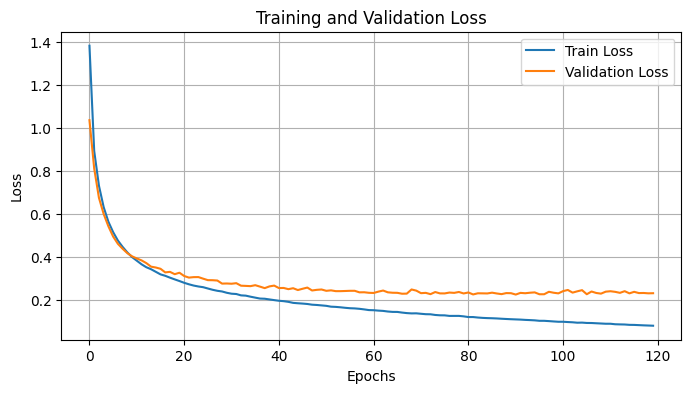

In [9]:
# Loss curves
plt.figure(figsize=(8,4))
plt.plot(history["loss"], label="Train Loss")
plt.plot(history["val_loss"], label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.grid(True)
plt.show()

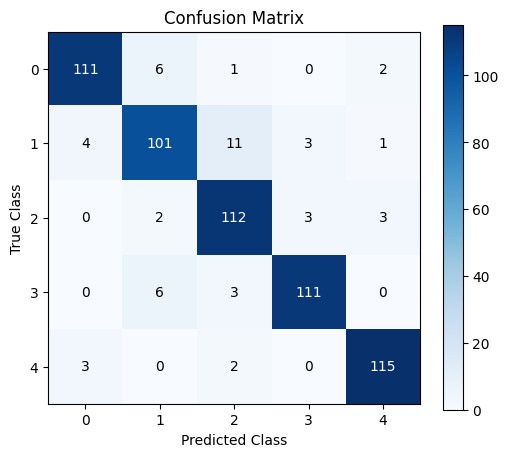

In [10]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.colorbar()
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i,j], ha="center", va="center", color="white" if cm[i,j]>cm.max()/2 else "black")
plt.show()